In [2]:
import json

# we look at path "./eval_scores", in which there are json files with scores
import os
from qq import LanguageData, TagType
from urielplus import urielplus
import logging

u = urielplus.URIELPlus()
u.set_cache(True)
try:
    u.integrate_grambank()
except SystemExit as e:
    print(e, "already using GramBank")
try:
    u.set_glottocodes()
except SystemExit as e:
    print(e, "already using Glottocodes")

ld = LanguageData.from_db()

# 1) This will silence INFO and DEBUG messages globally:
logging.getLogger().setLevel(logging.WARNING)

# —or—

# 2) Disable INFO (and below) altogether:
logging.disable(logging.INFO)

2025-05-30 12:33:07,180 - root - ERROR - GRAMBANK database already integrated.
2025-05-30 12:33:07,181 - root - ERROR - Already using Glottocodes.


1 already using GramBank
1 already using Glottocodes


# Overall top method analysis

In [3]:
import math
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

scores = {"ner": {}, "pos": {}, "copa": {}, "qa": {}}
f1 = {"ner": "eval_f1", "copa": "eval_acc", "pos": "eval_f1_macro", "qa": "f1"}
inf = math.inf
# From huggingface api, with our trained adapters (eu, sr)
existing_adapters = [
    "th",
    "my",
    "hi",
    "ilo",
    "ht",
    "tr",
    "mi",
    "vi",
    "is",
    "it",
    "ta",
    "jv",
    "ja",
    "sw",
    "qu",
    "de",
    "el",
    "et",
    "ru",
    "gn",
    "id",
    "en",
    "ar",
    "es",
    "tk",
    "zh",
    "mhr",
    "cdo",
    "xmf",
    "eu",
    "sr",
]
# scraped from cc-100 website
xlm_included_langs = [
    "af",
    "am",
    "ar",
    "as",
    "az",
    "be",
    "bg",
    "bn",
    "br",
    "bs",
    "ca",
    "cs",
    "cy",
    "da",
    "de",
    "el",
    "en",
    "eo",
    "es",
    "et",
    "eu",
    "fa",
    "ff",
    "fi",
    "fr",
    "fy",
    "ga",
    "gd",
    "gl",
    "gn",
    "gu",
    "ha",
    "he",
    "hi",
    "hr",
    "ht",
    "hu",
    "hy",
    "id",
    "ig",
    "is",
    "it",
    "ja",
    "jv",
    "ka",
    "kk",
    "km",
    "kn",
    "ko",
    "ku",
    "ky",
    "la",
    "lg",
    "li",
    "ln",
    "lo",
    "lt",
    "lv",
    "mg",
    "mk",
    "ml",
    "mn",
    "mr",
    "ms",
    "my",
    "ne",
    "nl",
    "no",
    "ns",
    "om",
    "or",
    "pa",
    "pl",
    "ps",
    "pt",
    "qu",
    "rm",
    "ro",
    "ru",
    "sa",
    "si",
    "sc",
    "sd",
    "sk",
    "sl",
    "so",
    "sq",
    "sr",
    "ss",
    "su",
    "sv",
    "sw",
    "ta",
    "te",
    "th",
    "tl",
    "tn",
    "tr",
    "ug",
    "uk",
    "ur",
    "uz",
    "vi",
    "wo",
    "xh",
    "yi",
    "yo",
    "zu",
    "zh",
]
for file in os.listdir("../eval_scores/selected"):
    if file.endswith(".json"):
        try:
            with open(os.path.join("../eval_scores/selected", file), "r") as f:
                data = json.load(f)
                task_name = file.split(".")[0]

                scores[task_name] = data

        except json.JSONDecodeError:
            print(f"Error decoding JSON for file: {file}")
        except KeyError:
            print("KeyError:", file)
langs = set()
tasks = ["ner", "pos", "copa", "qa"]
for task in tasks:
    for lang_name in scores[task]:
        if "reconstructed_featural" not in scores[task][lang_name].keys():
            continue
        langs.add(lang_name)
# we remove all languages from score that are not in langs
for task_name in scores:
    for lang_name in list(scores[task_name].keys()):
        if lang_name not in langs:
            del scores[task_name][lang_name]
# we make a subset consisting of only the languages for which an adapter exists
scores_subset = {}
no_adapter = {}
for task_name in scores:
    scores_subset[task_name] = {}
    no_adapter[task_name] = {}
    for lang_name in scores[task_name]:
        if lang_name not in langs:
            continue
        if lang_name in existing_adapters:
            scores_subset[task_name][lang_name] = scores[task_name][lang_name]
        else:
            no_adapter[task_name][lang_name] = scores[task_name][lang_name]

xlm_included = {}
xlm_not_included = {}
for task_name in scores:
    xlm_included[task_name] = {}
    xlm_not_included[task_name] = {}
    for lang_name in scores[task_name]:
        if lang_name in xlm_included_langs:
            xlm_included[task_name][lang_name] = scores[task_name][lang_name]
        else:
            xlm_not_included[task_name][lang_name] = scores[task_name][lang_name]


def get_significance(task_name, option1, option2, alternative="two-sided", subset=scores):
    all_scores1 = []
    all_scores2 = []
    if task_name == "all":
        task_names = subset.keys()
    elif type(task_name) is str:
        task_names = [task_name]
    else:
        task_names = task_name
    for task_name in task_names:
        for lang_name in subset[task_name]:
            if option1 in subset[task_name][lang_name] and option2 in subset[task_name][lang_name]:
                score1 = subset[task_name][lang_name][option1]
                score2 = subset[task_name][lang_name][option2]
                if task_name == "qa":
                    # we divide the scores of qa by 100
                    score1 = score1 / 100
                    score2 = score2 / 100
                all_scores1.append(score1)
                all_scores2.append(score2)
    print("average scores")
    print(f"{option1}: {np.mean(all_scores1)}")
    print(f"{option2}: {np.mean(all_scores2)}")
    t_stat, p_val = stats.ttest_rel(all_scores1, all_scores2, alternative=alternative)
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_val}")
    return t_stat, p_val


# we retrieve means of all scores, across languages
means = {}
for task_name in scores:
    means[task_name] = {}
    for lang_name in scores[task_name]:
        for key in scores[task_name][lang_name]:
            if key not in means[task_name]:
                means[task_name][key] = []
            means[task_name][key].append(scores[task_name][lang_name][key])
    for key in means[task_name]:
        means[task_name][key] = np.mean(means[task_name][key])
token_overlap = {}
for file in os.listdir("../data/token_overlap"):
    if file.endswith(".json"):
        try:
            with open(os.path.join("../data/token_overlap", file), "r") as f:
                data = json.load(f)
                file_name = file.split(".")[0]
                els = file_name.split("_")
                task = els[0]
                token_overlap[task] = {}
                for lang, values in data.items():
                    if lang not in token_overlap[task].keys():
                        token_overlap[task][lang] = {}
                    for key, value in values.items():
                        if key == "token_coverage":
                            token_overlap[task][lang]["token_coverage"] = value
                        elif key == "type_overlap":
                            token_overlap[task][lang]["type_overlap"] = value

        except json.JSONDecodeError:
            print(f"Error decoding JSON for file: {file}")
        except KeyError:
            print("KeyError:", file)

In [4]:
# we print the top 3 highest mean score for each task, and the english adapter baseline
top_methods = {}
for task_name in means:
    top_methods[task_name] = {}
    print(f"Task: {task_name}")
    sorted_means = sorted(means[task_name].items(), key=lambda x: x[1], reverse=True)
    for i in range(3):
        print(f"{sorted_means[i][0]}: {sorted_means[i][1]}")
        top_methods[task_name][sorted_means[i][0]] = sorted_means[i][0]
    print("finetune baseline:", means[task_name]["finetune"])
    print("reconstructed base method:", means[task_name]["reconstructed_featural"])
    print()

Task: ner
reconstructed_featural_limit: 0.5149050084607493
reconstructed_syntactic_limit: 0.5136309070887364
reconstructed_morphological_limit: 0.5112425745082357
finetune baseline: 0.3921577086734175
reconstructed base method: 0.5013399275268126

Task: pos
reconstructed_featural_eu: 0.46910944813280614
reconstructed_featural_sr: 0.4691048132438308
reconstructed_morphological_threshold: 0.4688215714892937
finetune baseline: 0.40026520216883055
reconstructed base method: 0.4679441087506307

Task: copa
baseline_closest_featural: 0.5645454545454546
reconstructed_featural_limit: 0.5590909090909091
reconstructed_morphological_limit: 0.5572727272727273
finetune baseline: 0.5552727272727273
reconstructed base method: 0.5498181818181818

Task: qa
reconstructed_morphological_threshold: 0.7285715530023293
reconstructed_morphological_limit: 0.7284004003755643
reconstructed_featural_limit: 0.7281344543568334
finetune baseline: 0.5336718068640248
reconstructed base method: 0.7271252762822759


C:\Users\stefa\AppData\Local\Temp\ipykernel_41336\2473946998.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
C:\Users\stefa\AppData\Local\Temp\ipykernel_41336\2473946998.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
C:\Users\stefa\AppData\Local\Temp\ipykernel_41336\2473946998.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
C:\Users\stefa\AppData\Local\Temp\ipykernel_41336\2473946998.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


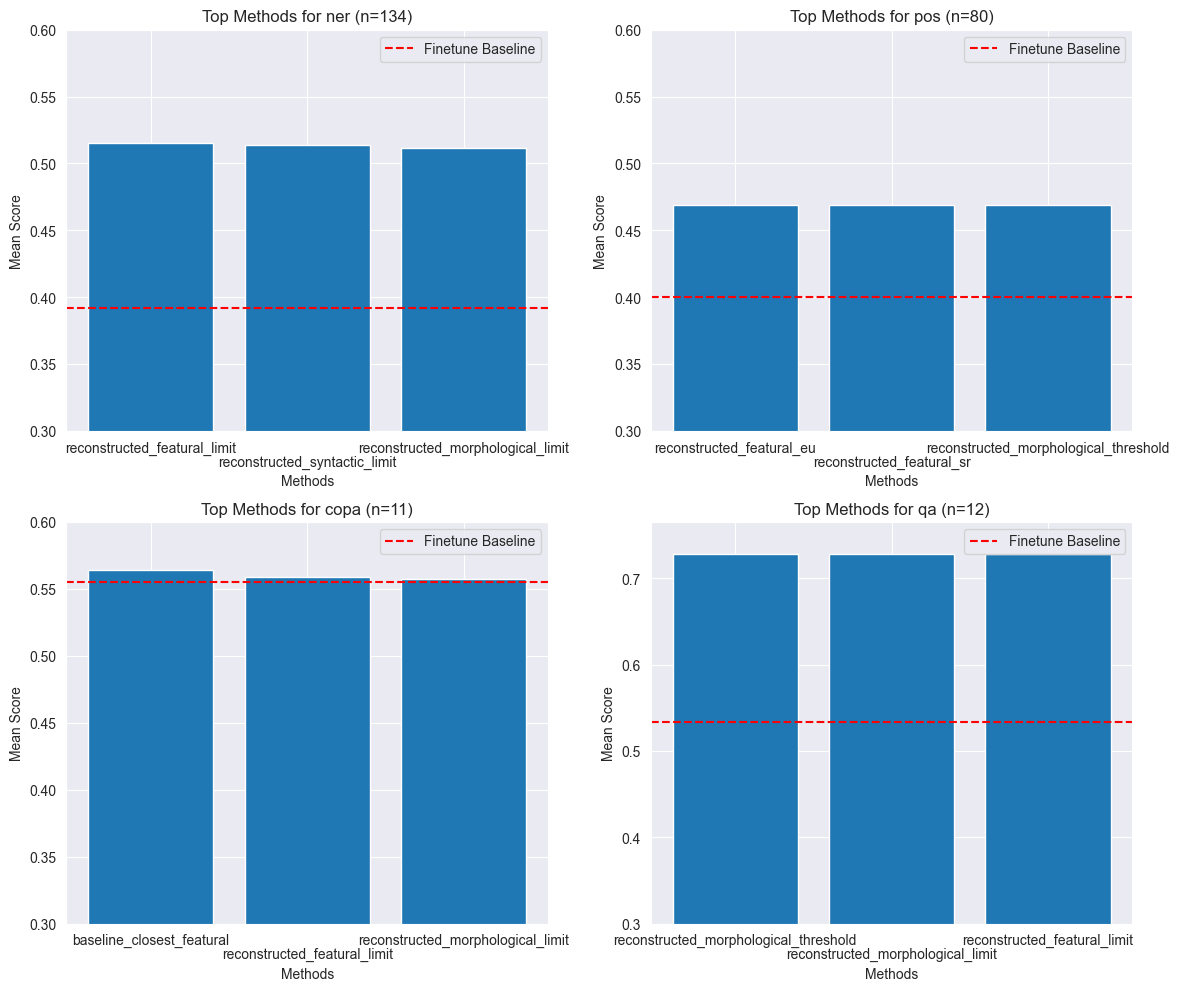

In [5]:
def plot_top_methods(task_name, top_methods, means, ax):
    task_means = means[task_name]
    top_keys = list(top_methods[task_name].keys())
    top_values = [task_means[key] for key in top_keys]
    ax.bar(top_keys, top_values)
    ax.axhline(y=task_means["finetune"], color="r", linestyle="--", label="Finetune Baseline")
    ax.set_title(f"Top Methods for {task_name} (n={len(scores[task_name])})")
    # we add subtitle: number of languages
    ax.set_xlabel("Methods")
    ax.set_ylabel("Mean Score")
    if task_name == "qa":
        ax.set_ylim(0.3, None)
    else:
        ax.set_ylim(0.3, 0.6)
    ax.legend()
    # Adjust x-axis labels to avoid overlap
    labels = ax.get_xticklabels()
    for i, label in enumerate(labels):
        if i % 2 == 1:  # Shift every second label
            label.set_y(label.get_position()[1] - 0.035)
    ax.set_xticklabels(labels)


# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot each task in a separate subplot
for i, task_name in enumerate(top_methods):
    if i < 4:  # Ensure only 4 tasks are plotted
        plot_top_methods(task_name, top_methods, means, axes[i])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Language - Task table
We make a table of scores per language, with columns for each task

In [6]:
# Initialize a dictionary to store data for the DataFrame
language_data = {}

# Iterate through tasks and languages to extract relevant data
for task_name in ["ner", "pos", "copa", "qa"]:
    for lang_name in scores[task_name]:
        if lang_name not in language_data:
            language_data[lang_name] = {}
        for key in scores[task_name][lang_name]:
            if key in ["reconstructed_featural", "finetune"]:
                if task_name not in language_data[lang_name]:
                    language_data[lang_name][task_name] = {}
                language_data[lang_name][task_name][key] = scores[task_name][lang_name][key]

# Convert the nested dictionary into a DataFrame with a multi-index
df = pd.DataFrame.from_dict(
    {(lang, task): data for lang, tasks in language_data.items() for task, data in tasks.items()}, orient="index"
)

# Set the multi-index with language and task
df.index = pd.MultiIndex.from_tuples(df.index, names=["Language", "Task"])

# Display the resulting DataFrame
print(df)

               finetune  reconstructed_featural
Language Task                                  
ace      ner   0.209115                0.364238
af       ner   0.634340                0.726658
         pos   0.587463                0.715957
als      ner   0.358047                0.606316
am       ner   0.335260                0.367816
...                 ...                     ...
tpn      pos   0.185121                0.131141
wbp      pos   0.138507                0.133479
wo       pos   0.146187                0.199334
yue      pos   0.302430                0.335064
ht       copa  0.486000                0.478000

[237 rows x 2 columns]


In [7]:
# starting from `df` (index: Language, Task; columns: reconstructed_featural, finetune)

# 1) unstack the Task level into columns
df2 = df.unstack(level="Task")

# 2) swap the column levels so that Task is outer, metric is inner
df2.columns = df2.columns.swaplevel(0, 1)

# 3) sort by task name
df2 = df2.sort_index(axis=1, level=0)

# give the column-index levels names
df2.columns.names = ["Task", "Metric"]

# build a Boolean DataFrame: True where a metric is NaN
is_na = df2.isna()

# for each task, check if all its metrics are NaN
#    this gives a DataFrame of shape (n_langs, 4 tasks)
# Deprecated: missing_task = is_na.groupby(level='Task', axis=1).all()
missing_task = is_na.T.groupby(level="Task").all().T
# count how many tasks are completely missing per language
n_missing = missing_task.sum(axis=1)

# keep only languages with at most 2 missing tasks
filtered_df = df2[n_missing <= 1]

filtered_df

Task         copa                              ner                         \
Metric   finetune reconstructed_featural  finetune reconstructed_featural   
Language                                                                    
ar            NaN                    NaN  0.230686               0.361266   
de            NaN                    NaN  0.599442               0.711901   
el            NaN                    NaN  0.511275               0.699429   
en            NaN                    NaN  0.765794               0.784810   
es            NaN                    NaN  0.564284               0.719115   
et          0.584                  0.564  0.551324               0.642795   
hi            NaN                    NaN  0.474167               0.641638   
id          0.578                  0.584  0.415720               0.476510   
it          0.566                  0.562  0.658940               0.735425   
ro            NaN                    NaN  0.578720               0.646164   
ru            NaN                    NaN  0.457403               0.609814   
ta          0.556                  0.556  0.121739               0.400606   
th          0.550                  0.578  0.001750               0.039036   
tr          0.550                  0.558  0.510366               0.596380   
vi          0.574                  0.584  0.610865               0.640354   
zh          0.596                  0.606  0.070803               0.188908   

Task           pos                               qa                         
Metric    finetune reconstructed_featural  finetune reconstructed_featural  
Language                                                                    
ar        0.484426               0.544133  0.234367               0.674457  
de        0.693568               0.741805  0.610861               0.754284  
el        0.593793               0.606112  0.527849               0.728946  
en        0.824975               0.825468  0.811572               0.832839  
es        0.625690               0.679653  0.610574               0.754347  
et        0.500778               0.641825       NaN                    NaN  
hi        0.488472               0.576364  0.338192               0.685695  
id        0.657028               0.659888       NaN                    NaN  
it        0.546795               0.666174       NaN                    NaN  
ro        0.548537               0.662538  0.623874               0.789080  
ru        0.646551               0.652222  0.581985               0.743189  
ta        0.382951               0.395184       NaN                    NaN  
th        0.329178               0.355209  0.456854               0.691096  
tr        0.424006               0.529784  0.468949               0.679470  
vi        0.349651               0.372400  0.617961               0.737137  
zh        0.317503               0.230317  0.521021               0.654963

In [8]:
# 1) Compute per-column stats:
df_for_latex = filtered_df.rename(columns={"reconstructed_featural": r"reconstructed\_featural"}, level="Metric")

# 1) Compute per-column stats on the *renamed* DataFrame
col_stats = {}
for col in df_for_latex.columns:
    vals = df_for_latex[col].dropna().astype(float)
    mn, md, mx = vals.min(), float(np.median(vals)), vals.max()
    col_stats[col] = (mn, md, mx)

# 2) Build your formatters dict using exactly the same column keys
formatters = {}
for col, (mn, md, mx) in col_stats.items():
    """fmt = lambda x, mn=mn, md=md, mx=mx: (
        f"\\tgrad[{mn:.3f}][{md:.3f}][{mx:.3f}]{{{x:.3f}}}"
        if not pd.isna(x) else ""
    )"""

    def fmt(x, mn=mn, md=md, mx=mx):
        if pd.isna(x):
            return ""
        return f"\\tgrad[{mn:.3f}][{md:.3f}][{mx:.3f}]{{{x:.3f}}}"

    formatters[col] = fmt

# 3) Export to LaTeX
latex_table = df_for_latex.to_latex(
    escape=False,
    formatters=formatters,
    multirow=True,
)
print(latex_table)

\begin{tabular}{lrrrrrrrr}
\toprule
Task & \multicolumn{2}{r}{copa} & \multicolumn{2}{r}{ner} & \multicolumn{2}{r}{pos} & \multicolumn{2}{r}{qa} \\
Metric & finetune & reconstructed\_featural & finetune & reconstructed\_featural & finetune & reconstructed\_featural & finetune & reconstructed\_featural \\
Language &  &  &  &  &  &  &  &  \\
\midrule
ar & NaN & NaN & \tgrad[0.002][0.511][0.766]{0.231} & \tgrad[0.039][0.641][0.785]{0.361} & \tgrad[0.318][0.524][0.825]{0.484} & \tgrad[0.230][0.624][0.825]{0.544} & \tgrad[0.234][0.555][0.812]{0.234} & \tgrad[0.655][0.733][0.833]{0.674} \\
de & NaN & NaN & \tgrad[0.002][0.511][0.766]{0.599} & \tgrad[0.039][0.641][0.785]{0.712} & \tgrad[0.318][0.524][0.825]{0.694} & \tgrad[0.230][0.624][0.825]{0.742} & \tgrad[0.234][0.555][0.812]{0.611} & \tgrad[0.655][0.733][0.833]{0.754} \\
el & NaN & NaN & \tgrad[0.002][0.511][0.766]{0.511} & \tgrad[0.039][0.641][0.785]{0.699} & \tgrad[0.318][0.524][0.825]{0.594} & \tgrad[0.230][0.624][0.825]{0.606} & \tgr

# Scores presented on a map
Not the most informative for analysis, but shows some info about which language families work better.


In [9]:
from huggingface_hub import HfApi
from qq import LanguageData

ld = LanguageData.from_db()

api = HfApi()
# Fetch all AdapterHub xlm-roberta-base adapters
models = api.list_models(author="AdapterHub", library="adapter-transformers", search="xlm-roberta-base-")
# we print all found models

to_load = {
    m.modelId: m.modelId.split("xlm-roberta-base-")[-1].rsplit("-wiki_pfeiffer", 1)[0]
    for m in models
    if m.modelId.startswith("AdapterHub/xlm-roberta-base-") and m.modelId.endswith("-wiki_pfeiffer")
}


def get_glots(iso_list):
    manuals = {
        "Arabic": "arab1267",
        "Swahili": "swah1253",
        "Bengali": "beng1282",
        "Chinese": "mand1415",
        "Persian": "west2369",
        "Yoruba": "ilaa1246",
        "Nepali": "nepa1254",
        "Quechua": "cusc1236",
        "Estonian": "esto1258",
        "Guarani": "east2555",
    }

    glots = {}
    probs = []

    for lang in iso_list:
        eng = ld.get(lang, tag_type=TagType.BCP_47_CODE).english_name
        glot = ld.get(lang, tag_type=TagType.BCP_47_CODE).glottocode
        # we need to find if glot is in distances
        if not glot:
            if eng in manuals.keys():
                glot = manuals[eng]
        if eng and glot:
            glots[eng] = (lang, glot)
        else:
            probs.append(lang)

    print("no glottocodes found for these languages: ", probs)

    return glots


glots = get_glots(to_load.values())
iso_list = []
iso_s = [scores[key].keys() for key in scores.keys()]


# iso_list = [scores[key].keys() for key in scores.keys()]
for el in iso_s:
    for iso in el:
        iso_list.append(iso)
eval_glots = get_glots(iso_list)

no glottocodes found for these languages:  []
no glottocodes found for these languages:  []


In [10]:
import geopandas as gpd


def load_and_preprocess_data(file_path, filter_languages=False):
    data = pd.read_csv(file_path)
    if filter_languages:
        # we map "ISO" to "script"
        data_f = data[data["ISO"].isin([lang[0] for lang in filter_languages])]
        # we map "ISO" to "script"
        # Create a new DataFrame with the 'script' column
        script_df = pd.DataFrame(data_f["ISO"].map({lang[0]: lang[1] for lang in filter_languages}), columns=["script"])
        # Use pd.concat to join the new DataFrame with the original DataFrame
        data = pd.concat([data_f, script_df], axis=1)
    data.replace("NaN", np.nan, inplace=True)
    df = data.set_index("WALS-ID").iloc[:, 10:]
    df.fillna(0, inplace=True)
    df_encoded = df.apply(lambda col: pd.factorize(col)[0] if col.dtypes == "O" else col)
    return data, df_encoded


data, df = load_and_preprocess_data("../typdiv-sampling/data/wals_dedup.csv")

In [11]:
# we check for all languages in glots if they are in the data
# we first check the glottocode, if that is not found we go to ISO
def get_geo_data(glots, data):
    geo_data = {}
    excluded = []
    for lang, codes in glots.items():
        iso, glot = codes
        if glot in data["Glottocode"].values:
            # print(f"{lang} is in the data with glot {glot}")
            geo_data[iso] = (
                data[data["Glottocode"] == glot]["Longitude"].values[0],
                data[data["Glottocode"] == glot]["Latitude"].values[0],
            )

        elif iso in data["ISO"].values:
            # print(f"{lang} is in the data with iso {iso}")
            geo_data[iso] = (
                data[data["ISO"] == iso]["Longitude"].values[0],
                data[data["ISO"] == iso]["Latitude"].values[0],
            )

        else:
            print(f"{lang} is not in the data")
            excluded.append(lang)
    return geo_data, excluded


geo_data_dict, excluded = get_geo_data(glots, data)
eval_geo_data_dict, eval_excluded = get_geo_data(eval_glots, data)

Indonesian is not in the data
Tosk Albanian is not in the data
Aragonese is not in the data
Aymara is not in the data
Corsican is not in the data
Esperanto is not in the data
Extremaduran is not in the data
Friulian is not in the data
Gan Chinese is not in the data
Croatian is not in the data
Indonesian is not in the data
Kurmanji Kurdish is not in the data
Lombard is not in the data
Mongolian is not in the data
Nepali is not in the data
Ossetian is not in the data
Western Panjabi is not in the data
Pashto is not in the data
Sicilian is not in the data
Scots is not in the data
Albanian is not in the data
Serbian is not in the data
Uzbek is not in the data
Vlaams is not in the data
Akuntsu is not in the data
Russia Buriat is not in the data
Mbyá Guaraní is not in the data
Livvi is not in the data
Skolt Sami is not in the data


In [12]:
import matplotlib.colors as mcolors


def visualize_on_map(data, task, vis_column="unseen", save_path=None, training_vis=True):
    # Create a GeoDataFrame from the data
    gdf = gpd.GeoDataFrame(data, columns=data.columns, geometry=gpd.points_from_xy(data["Longitude"], data["Latitude"]))

    # Create a world map
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    # Plot the world map
    fig, ax = plt.subplots(figsize=(15, 10))
    world.boundary.plot(ax=ax, linewidth=1, edgecolor="black", zorder=0)

    vmin = gdf[vis_column].min()
    vmax = gdf[vis_column].max()
    try:
        norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # Center at 0 for red-green mapping
        cmap = plt.get_cmap("RdYlGn")
    except ValueError:
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # No center for other cases (all pos or negative, for example)
        cmap = plt.get_cmap("Greens" if vmin >= 0 else "Reds")  # Choose a color map based on the range of values

    # 3. Choose a colormap (e.g. viridis, plasma, inferno, etc.)

    # 4. Create the plot
    # fig, ax = plt.subplots(figsize=(8, 8))

    # (Optional) Plot a light basemap or boundary first:
    # world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    # world.to_crs(gdf.crs).plot(ax=ax, color='lightgrey', edgecolor='white')

    # 5. Plot points colored by 'vis_column'
    gdf.plot(
        ax=ax,
        column=vis_column,
        cmap=cmap,
        norm=norm,
        markersize=20,  # adjust point size as needed
        edgecolor="k",  # black edge for better visibility
        linewidth=0.2,
        zorder=5,
    )
    # we add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    # we plot the colorbar, slightly smaller than the map
    cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.04)
    cbar.set_label(vis_column)

    # 6. Add title and labels
    ax.set_title(f"Improvement relative to Fine-tuning baseline for {task.upper()}", fontsize=15)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()

In [13]:
# we print the highest 3 key-value pairs in a combination
def get_highest(task, language):
    result = (-inf, None)
    try:
        for type, value in scores[task][language].items():
            # value = value*100
            if "reconstructed" in type:
                if value > result[0]:
                    result = (value, type)
    except KeyError:
        print(f"KeyError: {task} or {language} not found in scores")
    return result

C:\Users\stefa\AppData\Local\Temp\ipykernel_41336\1766993597.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


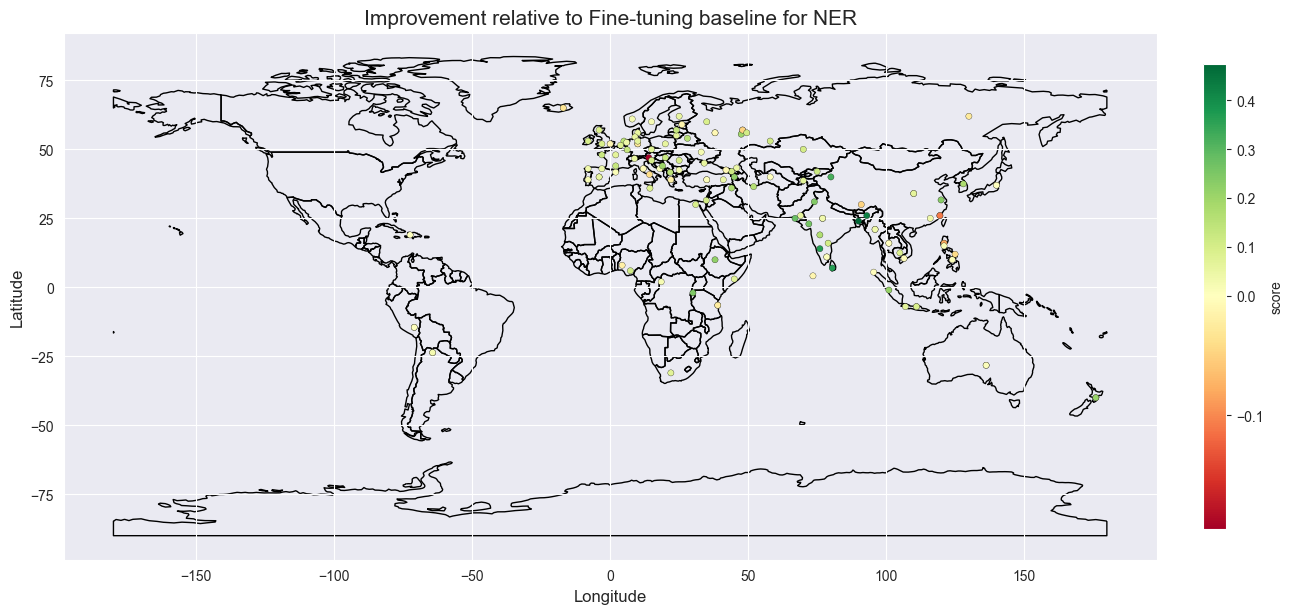

C:\Users\stefa\AppData\Local\Temp\ipykernel_41336\1766993597.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


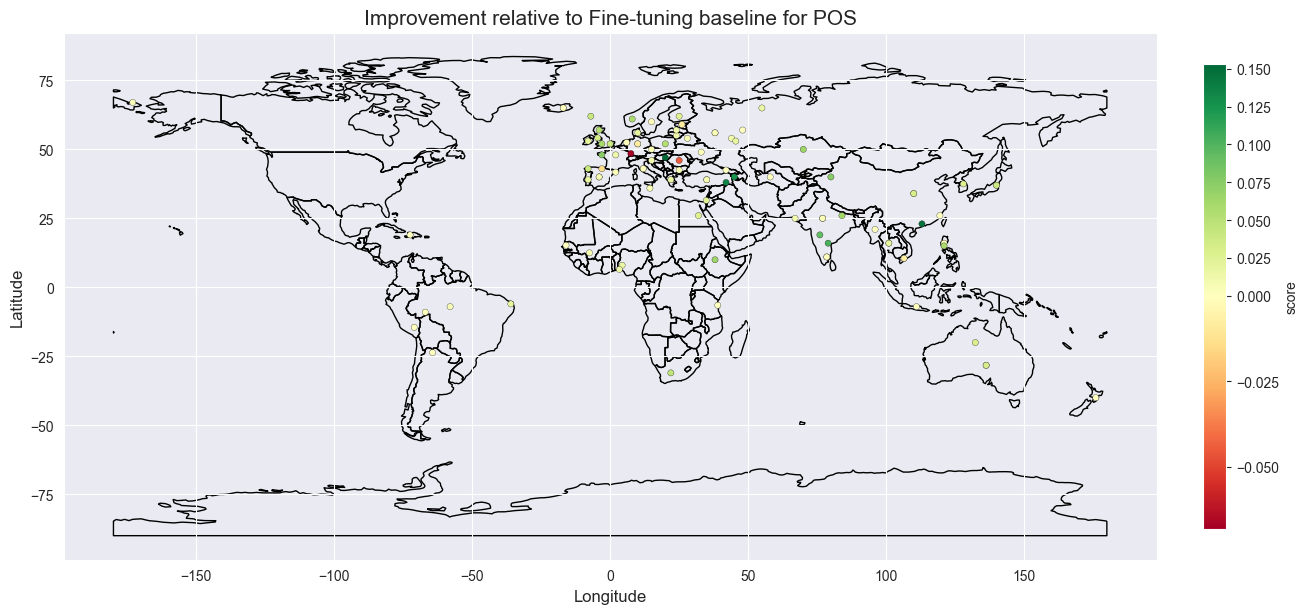

In [14]:
# we transform geo_data into a pandas dataframe with lang as index and longitude and latitude as columns
geo_data = pd.DataFrame.from_dict(geo_data_dict, orient="index", columns=["Longitude", "Latitude"])
eval_geo_data = pd.DataFrame.from_dict(eval_geo_data_dict, orient="index", columns=["Longitude", "Latitude"])
# we add a column 'train' and 'eval' to the dataframes and then join them
geo_data["unseen"] = 0
eval_geo_data["unseen"] = 1
geo_data["score"] = 0
vis_column = "score"

for task in ["ner", "pos"]:
    # we map the scores from "diffs" to the geo_data
    temp_geo_data = eval_geo_data.copy()
    for lang in temp_geo_data.index:
        if lang in scores[task].keys() and "reconstructed_featural" in scores[task][lang].keys():
            best_score = get_highest(task, lang)[0]
            temp_geo_data.loc[lang, "score"] = best_score - scores[task][lang]["baseline_closest_featural"]
        else:
            # print("no data for", lang)
            continue

    joined_df = pd.concat([geo_data, temp_geo_data], axis=0)
    visualize_on_map(
        joined_df, task, vis_column=vis_column, save_path=f"../output/map_{task}_{vis_column}.png", training_vis=False
    )

In [15]:
import requests


def glotto_to_family(glotto_code: str) -> str:
    """
    Given a Glottocode (e.g. 'stan1293' for English), fetches
    Glottolog's JSON and returns the highest-level family.
    """
    url = f"https://glottolog.org/resource/languoid/id/{glotto_code}.json"
    resp = requests.get(url)
    resp.raise_for_status()
    data = resp.json()
    # classification is a list of dicts, each with 'name' and 'level'
    # find the one where level == "family"
    for node in data.get("classification", []):
        if node.get("level") == "family":
            return node["name"]
    # fallback: take the topmost entry
    if data.get("classification"):
        return data["classification"][0]["name"]
    return "Unknown"

In [16]:
families = {}
for name, codes in eval_glots.items():
    iso, glot = codes
    family = glotto_to_family(glot)
    families[iso] = family
    print(f"{iso} ({glot}) belongs to family: {family}")

ace (achi1257) belongs to family: Austronesian
af (afri1274) belongs to family: Indo-European
als (tosk1239) belongs to family: Indo-European
am (amha1245) belongs to family: Afro-Asiatic
an (arag1245) belongs to family: Indo-European
arz (egyp1253) belongs to family: Afro-Asiatic
ar (arab1267) belongs to family: Pama-Nyungan
as (assa1263) belongs to family: Indo-European
ay (nucl1667) belongs to family: Aymaran
bar (bava1246) belongs to family: Indo-European
ba (bash1264) belongs to family: Turkic
be (bela1254) belongs to family: Indo-European
bg (bulg1262) belongs to family: Indo-European
bn (beng1280) belongs to family: Indo-European
bo (tibe1272) belongs to family: Sino-Tibetan
br (bret1244) belongs to family: Indo-European
bs (bosn1245) belongs to family: Indo-European
ca (stan1289) belongs to family: Indo-European
cdo (mind1253) belongs to family: Sino-Tibetan
ceb (cebu1242) belongs to family: Austronesian
ce (chec1245) belongs to family: Nakh-Daghestanian
ckb (cent1972) belongs 

In [17]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_on_map(
    data, task, vis_column="unseen", iso_to_family=None, marker_styles=None, save_path=None, training_vis=True
):
    """
    data: DataFrame with 'ISO','Longitude','Latitude',vis_column…
    iso_to_family: dict mapping ISO → family_name
    marker_styles: dict mapping family_name → matplotlib marker string
    """
    # GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data["Longitude"], data["Latitude"]))
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    fig, ax = plt.subplots(figsize=(15, 10))
    world.boundary.plot(ax=ax, linewidth=1, edgecolor="black", zorder=0)

    # colour normalisation
    vmin, vmax = gdf[vis_column].min(), gdf[vis_column].max()
    try:
        norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        cmap = plt.get_cmap("RdYlGn")
    except ValueError:
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        cmap = plt.get_cmap("Greens" if vmin >= 0 else "Reds")

    # set up families & markers
    if iso_to_family is None:
        iso_to_family = {}
    families = sorted({iso_to_family.get(iso, "Unknown") for iso in gdf["ISO"]})
    if marker_styles is None:
        default_markers = ["o", "s", "^", "D", "v", "P", "X", "*"]
        marker_styles = {fam: default_markers[i % len(default_markers)] for i, fam in enumerate(families)}

    # plot each family separately
    for fam in families:
        subset = gdf[gdf["ISO"].map(iso_to_family).fillna("Unknown") == fam]
        if subset.empty:
            continue
        subset.plot(
            ax=ax,
            column=vis_column,
            cmap=cmap,
            norm=norm,
            markersize=50 if training_vis else 30,
            marker=marker_styles[fam],
            edgecolor="k",
            linewidth=0.3,
            label=fam,
            zorder=5,
        )

    # colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.04)
    cbar.set_label(vis_column)

    ax.legend(title="Family", loc="lower left", bbox_to_anchor=(1.01, 0))
    ax.set_title(f"Improvement relative to Fine-tuning baseline for {task.upper()}", fontsize=15)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.tight_layout()
    plt.show()

In [18]:
# we set index of "joined_df" to ISO explicitly
# we work with the existing joined_df
joined_df["ISO"] = joined_df.index

C:\Users\stefa\AppData\Local\Temp\ipykernel_41336\761959140.py:25: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


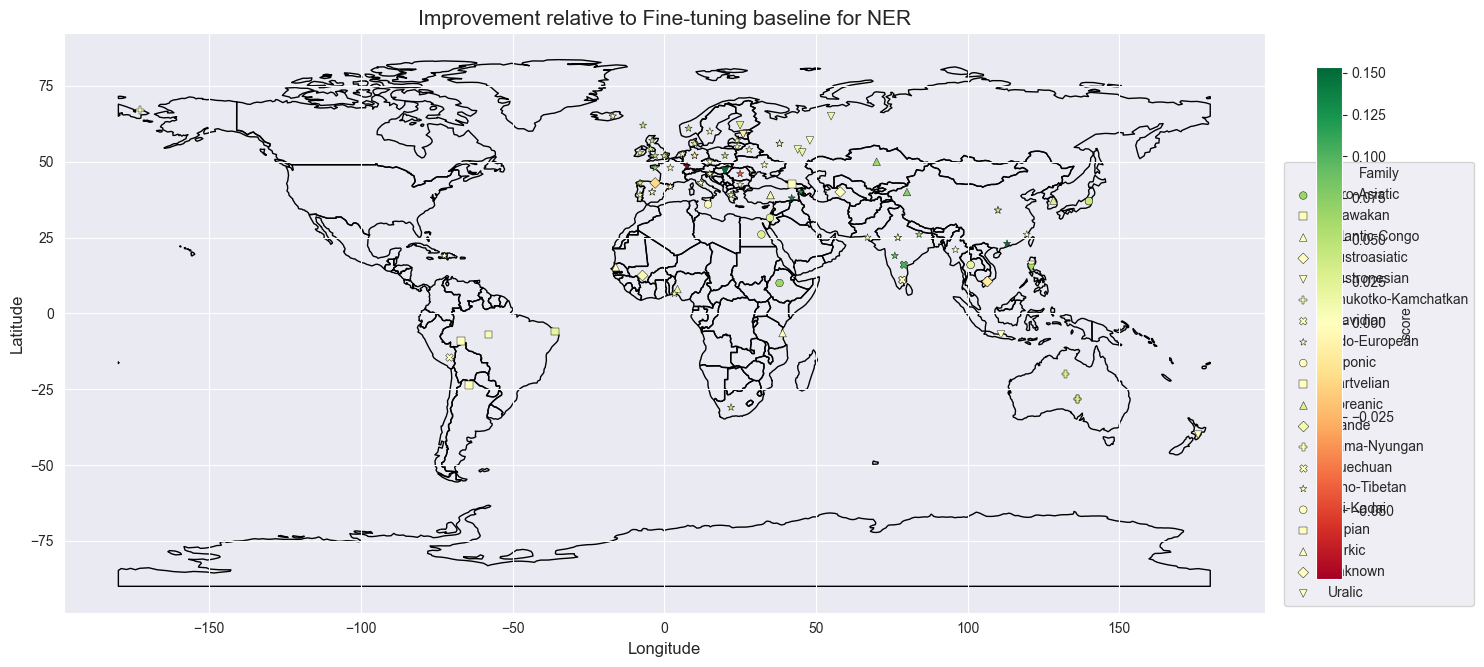

In [19]:
visualize_on_map(
    joined_df,
    task="ner",
    vis_column="score",
    iso_to_family=families,
    save_path="../output/map_ner_score.png",
    training_vis=False,
)

In [20]:
# we plot the scores of "reconstructed_featural" against "baseline_closest_featural", and give style to the markers based on the family
task = "ner"
df_select = pd.DataFrame.from_dict(
    {
        lang: get_highest(task, lang)[0]
        for lang in joined_df.index
        if lang in scores[task]
        and "reconstructed_featural" in scores[task][lang]
        and "baseline_closest_featural" in scores[task][lang]
    },
    columns=["reconstructed_featural"],
    orient="index",
)
df_select["baseline_closest_featural"] = pd.Series(
    {
        lang: scores[task][lang]["baseline_closest_featural"]
        for lang in df_select.index
        if lang in scores[task] and "baseline_closest_featural" in scores[task][lang]
    },
    index=df_select.index,
)
df_select

,reconstructed_featural,baseline_closest_featural
th,0.041465,0.042151
my,0.309963,0.270096
hi,0.657241,0.621109
ilo,0.565574,0.646288
tr,0.604243,0.600452
...,...,...
vep,0.519084,0.428571
war,0.606335,0.648148
wuu,0.277778,0.044944
yo,0.416667,0.436364


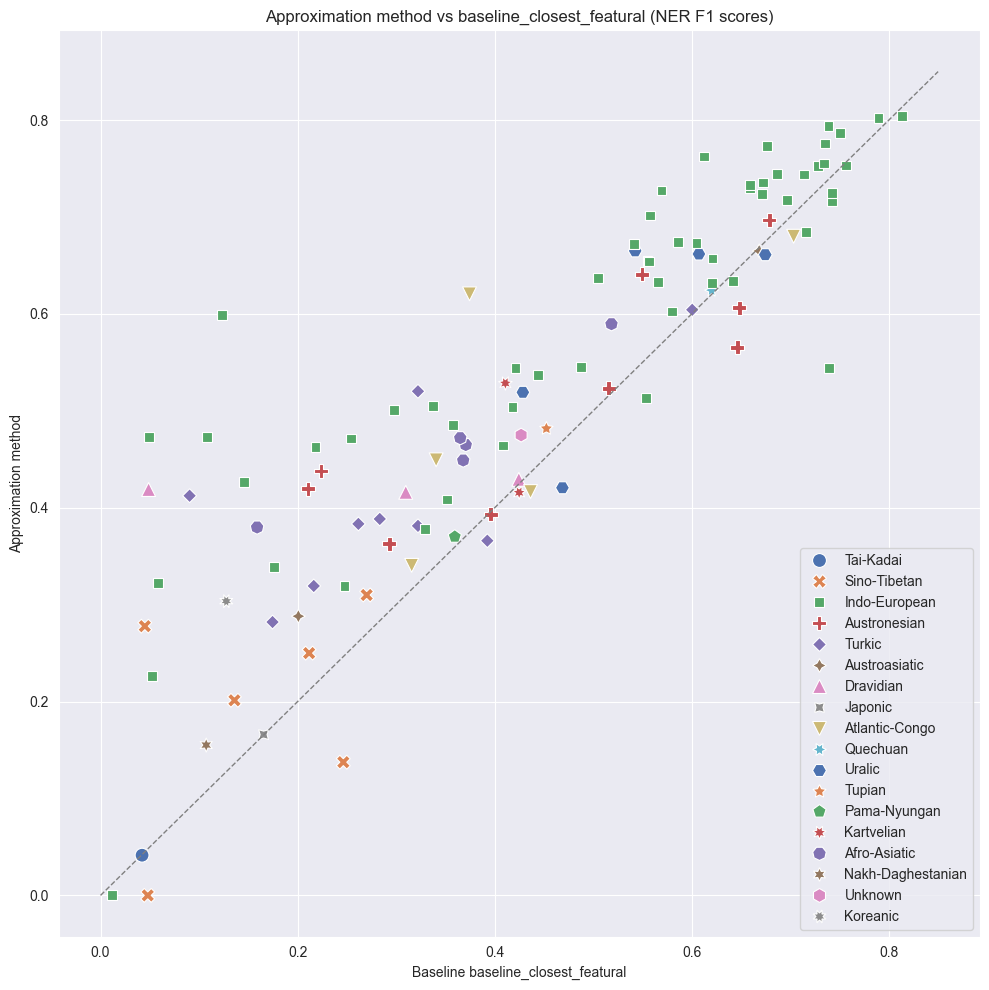

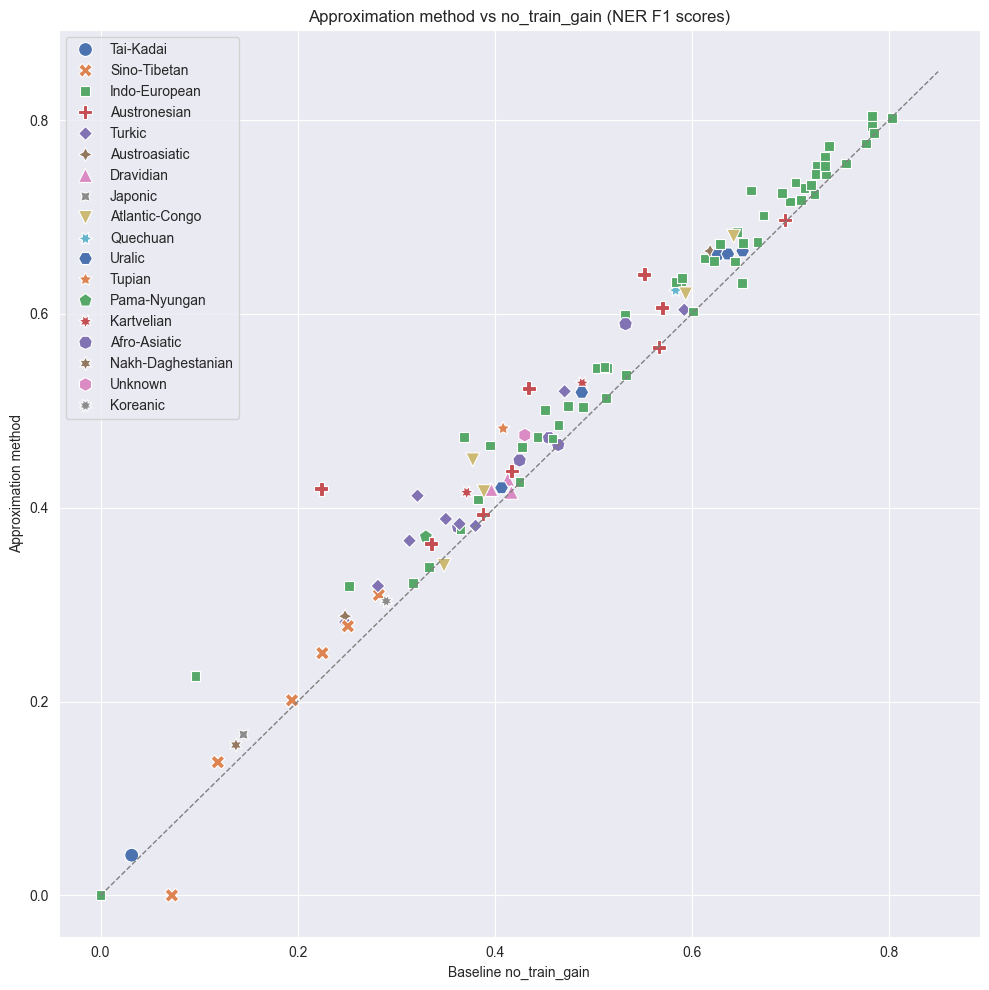

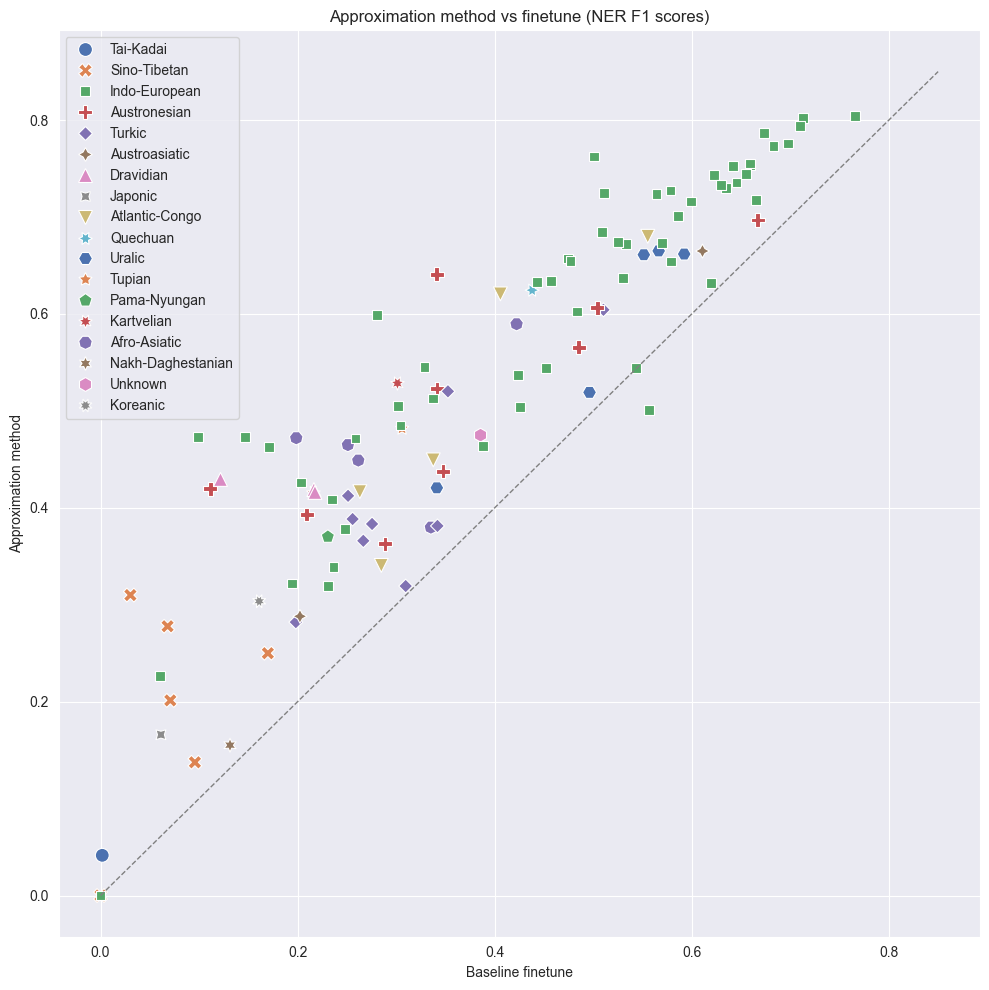

In [21]:
# we add the family to the df_select
custom_columns = ["baseline_closest_featural", "no_train_gain", "finetune"]
for custom_column in custom_columns:
    df_select["family"] = df_select.index.map(families)
    # we add the "baseline_closest_featural" and "reconstructed_featural" columns to the df_select
    df_select["baseline_closest_featural"] = df_select["baseline_closest_featural"].astype(float)
    df_select["reconstructed_featural"] = df_select["reconstructed_featural"].astype(float)
    df_select[custom_column] = df_select.index.map(
        lambda x: scores[task][x][custom_column] if x in scores[task] else np.nan
    )
    # we plot the scores
    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        data=df_select,
        x=custom_column,
        y="reconstructed_featural",
        hue="family",
        style="family",
        s=100,  # marker size
        palette="deep",
    )
    plt.title(f"Approximation method vs {custom_column} (NER F1 scores)")
    plt.xlabel(f"Baseline {custom_column}")
    plt.ylabel("Approximation method")
    # we add a diagonal line y=x
    plt.plot([0, 0.85], [0, 0.85], color="gray", linestyle="--", linewidth=1)
    plt.legend()

    plt.tight_layout()
    plt.savefig("../output/ner_scores_family.pdf", bbox_inches="tight", dpi=300)
    plt.show()

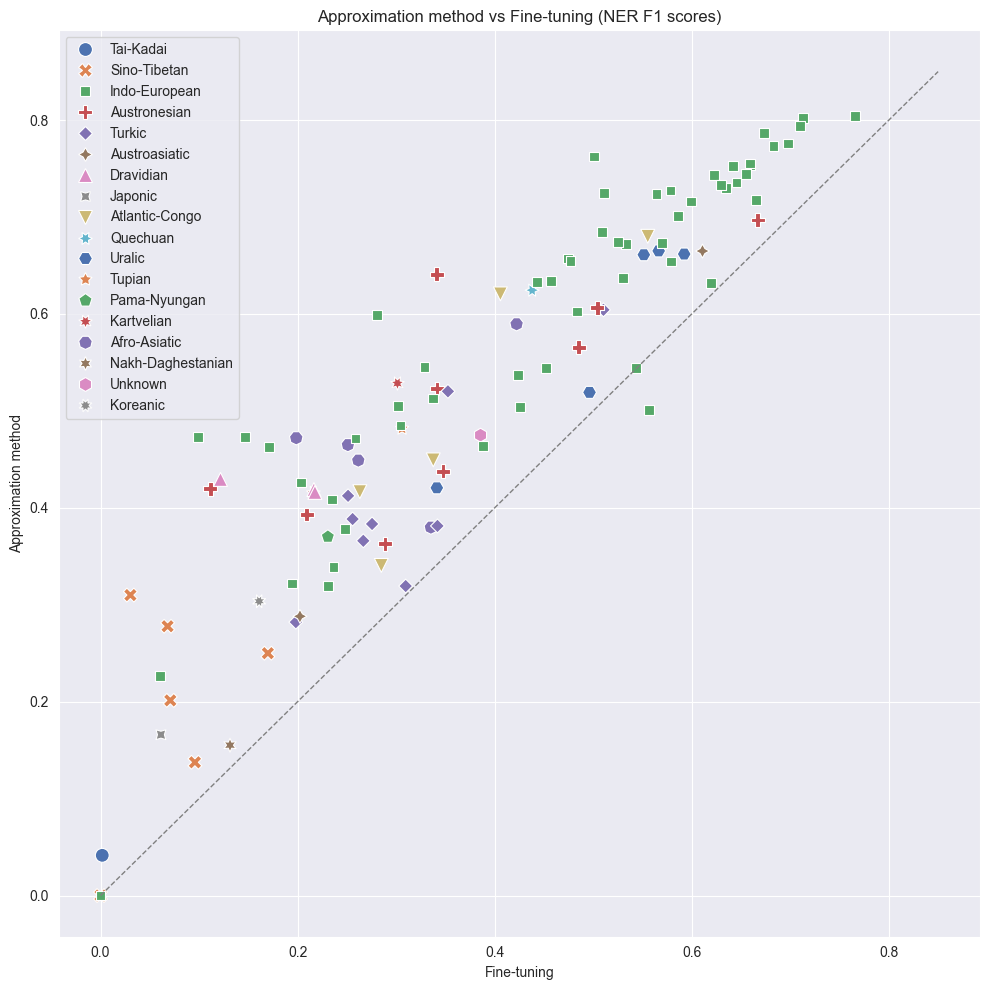

In [22]:
custom_column = "finetune"
df_select["family"] = df_select.index.map(families)
# we add the "baseline_closest_featural" and "reconstructed_featural" columns to the df_select
df_select["baseline_closest_featural"] = df_select["baseline_closest_featural"].astype(float)
df_select["reconstructed_featural"] = df_select["reconstructed_featural"].astype(float)
df_select[custom_column] = df_select.index.map(
    lambda x: scores[task][x][custom_column] if x in scores[task] else np.nan
)
# we plot the scores
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=df_select,
    x=custom_column,
    y="reconstructed_featural",
    hue="family",
    style="family",
    s=100,  # marker size
    palette="deep",
)
plt.title("Approximation method vs Fine-tuning (NER F1 scores)")
plt.xlabel("Fine-tuning")
plt.ylabel("Approximation method")
# we add a diagonal line y=x
plt.plot([0, 0.85], [0, 0.85], color="gray", linestyle="--", linewidth=1)
plt.legend()

plt.tight_layout()
plt.savefig("../output/ner_scores_family.pdf", bbox_inches="tight", dpi=300)
plt.show()

# Score depending on featural distance to English

In [23]:
def typological_distance(target, glots):
    """
    This function takes a target language and a list of languages.
    It weights the other languages depending on their closeness to the target language.
    """

    # 1. retrieve closeness score of all languages to target language
    weights = {}
    probs = []
    for lang, codes in glots.items():
        iso, glot = codes
        # get the distance
        try:
            dist = u.new_distance("featural", [glot, target])
            # print(f"Distance {lang} to {target}: {dist}")
        except Exception as e:
            print(f"Error {e}: {lang} - {glot} - {target}")
            probs.append(lang)
        weights[iso] = dist
    # delete the problematic from glots
    for lang in probs:
        del glots[lang]

    return weights

In [24]:
import pickle

dist_glots = eval_glots.copy()
typ_dists = typological_distance(ld.get("en", TagType.BCP_47_CODE).glottocode, dist_glots)
# we save this as a pickle
with open("../pickles/typ_dists.pkl", "wb") as f:
    pickle.dump(typ_dists, f)

In [25]:
# we define the diffs: the differences between the finetune and the reconstructed scores
tasks = ["ner", "pos", "copa", "qa"]
diffs = {task: {} for task in tasks}
for task in tasks:
    for lang in scores[task]:
        if "reconstructed_featural" in scores[task][lang].keys():
            if lang not in diffs[task].keys():
                diffs[task][lang] = {}
            diffs[task][lang]["improvement_finetune"] = (
                scores[task][lang]["reconstructed_featural"] - scores[task][lang]["finetune"]
            )
            diffs[task][lang]["improvement_madx"] = (
                scores[task][lang]["reconstructed_featural"] - scores[task][lang]["baseline_closest_featural"]
            )
            diffs[task][lang]["madx_baseline_en"] = (
                scores[task][lang]["baseline_closest_featural"] - scores[task][lang]["baseline_en"]
            )
        else:
            # print(f"{lang} not in diffs")
            continue

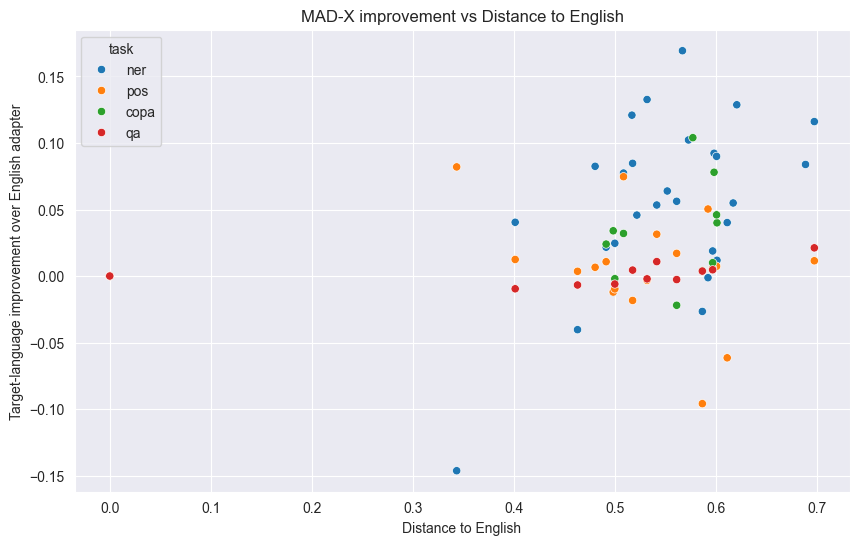

In [28]:
# we plot the distance to the difference in score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# we create a dataframe with the distance and the score for each task
dfs = {}
for task in tasks:
    df = pd.DataFrame.from_dict(typ_dists, orient="index", columns=["similarity"])
    # we map the "diff"
    for lang in df.index:
        if lang not in scores_subset[task].keys():
            df.drop(lang, inplace=True)
        elif lang in diffs[task].keys():
            df.loc[lang, "score"] = diffs[task][lang]["madx_baseline_en"]
        else:
            # print(f"{lang} not in diffs")
            # we remove the lang from the geo_data
            df.drop(lang, inplace=True)
    # we add the task as a column
    df["task"] = task
    dfs[task] = df
# we join the dataframes into one
df = pd.concat(dfs.values(), axis=0)

# we visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="similarity", y="score", hue="task")
plt.title("MAD-X improvement vs Distance to English")
plt.xlabel("Distance to English")
plt.ylabel("Target-language improvement over English adapter")
plt.savefig("../output/madx_improvement_eng.pdf", bbox_inches="tight", dpi=1000)
plt.show()

In [56]:
# we print the distance for the lowest similarity language for qa
lowest_similarity = df[df["task"] == "qa"].sort_values(by="similarity").iloc[0]
print(f"Lowest similarity language for QA: {lowest_similarity.name}")

Lowest similarity language for QA: en


In [57]:
# we plot the distance to the difference in score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# we create a dataframe with the distance and the score
df = pd.DataFrame.from_dict(typ_dists, orient="index", columns=["similarity"])
# we map the "diff"
for lang in df.index:
    if lang in diffs.keys():
        df.loc[lang, "score"] = diffs[lang]["improvement_finetune"]
    else:
        print(f"{lang} not in diffs")
        # we remove the lang from the geo_data
        df.drop(lang, inplace=True)

# we visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="similarity", y="score")
plt.title("Similarity to English vs Score")
plt.xlabel("Similarity to English")
plt.ylabel("Score")
plt.grid()
plt.show()

ace not in diffs
af not in diffs
als not in diffs
am not in diffs
an not in diffs
arz not in diffs
ar not in diffs
as not in diffs
ay not in diffs
bar not in diffs
ba not in diffs
be not in diffs
bg not in diffs
bn not in diffs
bo not in diffs
br not in diffs
bs not in diffs
ca not in diffs
cdo not in diffs
ceb not in diffs
ce not in diffs
ckb not in diffs
co not in diffs
crh not in diffs
cs not in diffs
cv not in diffs
cy not in diffs
da not in diffs
de not in diffs
diq not in diffs
dv not in diffs
el not in diffs
en not in diffs
eo not in diffs
es not in diffs
et not in diffs
eu not in diffs
ext not in diffs
fi not in diffs
fo not in diffs
frr not in diffs
fr not in diffs
fur not in diffs
fy not in diffs
gan not in diffs
ga not in diffs
gd not in diffs
gl not in diffs
gn not in diffs
gu not in diffs
hak not in diffs
he not in diffs
hi not in diffs
hr not in diffs
hu not in diffs
hy not in diffs
id not in diffs
ig not in diffs
ilo not in diffs
is not in diffs
it not in diffs
ja not in

ValueError: Could not interpret value `score` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

# Min distance
For each language, check what the minimal distance to a training included language is

In [39]:
import pickle

# we have calculated this before and saved as a pickle
# only calculate again if this has not happened
pickle_paths = ["../pickles/min_dists.pkl", "../pickles/max_dists.pkl"]
if os.path.exists(pickle_paths[0]) and os.path.exists(pickle_paths[1]):
    with open(pickle_paths[0], "rb") as f:
        min_dists = pickle.load(f)
    with open(pickle_paths[1], "rb") as f:
        max_dists = pickle.load(f)
else:
    min_dists = {eval_glot[1]: 1 for eval_glot in eval_glots.values()}
    max_dists = {eval_glot[1]: 0 for eval_glot in eval_glots.values()}
    all_dists = {eval_glot[1]: [] for eval_glot in eval_glots.values()}
    for key, value in min_dists.items():
        min_dist = value
        max_dist = max_dists[key]
        for glot in glots.values():
            try:
                dist = u.new_distance("featural", [glot[1], key])
                # print(dist)
                all_dists[key].append((glot[0], dist))
            except Exception:
                dist = False
                # print(e)
            except SystemExit:
                dist = False

            if dist:
                min_dist = min(min_dist, dist)
                max_dist = max(max_dist, dist)
        min_dists[key] = min_dist
        max_dists[key] = max_dist

    # we save this to a pickle and load it in later
    with open("../pickles/min_dists.pkl", "wb") as f:
        pickle.dump(min_dists, f)
    with open("../pickles/max_dists.pkl", "wb") as f:
        pickle.dump(max_dists, f)

In [40]:
average_distance = {}
for lang, distances in all_dists.items():
    if distances:
        average = sum([distance[1] for distance in distances]) / len(distances)
        average_distance[lang] = average
    else:
        average_distance[lang] = 0

NameError: name 'all_dists' is not defined

In [41]:
minima = {ev[0]: min_dists[ev[1]] for ev in eval_glots.values()}
maxima = {ev[0]: max_dists[ev[1]] for ev in eval_glots.values()}
avs = {ev[0]: average_distance[ev[1]] for ev in eval_glots.values()}
distance_types = {"Minimum_train_dist": minima, "Maximum_train_dist": maxima, "Average_train_dist": avs}
# we create a dataframe with the distance and the score
for name, distance_type in distance_types.items():
    df = pd.DataFrame.from_dict(distance_type, orient="index", columns=["distance"])
    # we map the "diff"
    for lang in df.index:
        if lang in diffs.keys():
            df.loc[lang, "score"] = diffs[lang]["improvement_finetune"]
        else:
            # print(f"{lang} not in diffs")
            # we remove the lang from the geo_data
            df.drop(lang, inplace=True)

    # we visualize
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x="distance", y="score")
    plt.title(f"{name} to adapters vs improvement over finetune")
    plt.xlabel(name)
    plt.ylabel("Score")
    plt.grid()
    plt.savefig(f"../output/{name}_distance_train.png", bbox_inches="tight", dpi=300)
    plt.show()

KeyError: 'achi1257'

# Score in function of token overlap

In [43]:
scores["ner"]

{'ace': {'finetune': 0.20911528150134046,
  'reconstructed_featural_base': 0.3624595469255664,
  'reconstructed_syntactic_distVar': 0.36065573770491804,
  'reconstructed_morphological_distVar': 0.36303630363036304,
  'reconstructed_featural_eu': 0.3514376996805112,
  'reconstructed_featural': 0.36423841059602646,
  'baseline_en': 0.3344262295081967,
  'baseline_task_adapter': 0.33333333333333337,
  'baseline_avg_adapter': 0.27272727272727276,
  'baseline_closest_featural': 0.3958333333333333,
  'no_train_gain': 0.3879598662207358,
  'reconstructed_featural_limit': 0.3576158940397351,
  'reconstructed_syntactic_limit': 0.36423841059602646,
  'reconstructed_morphological_limit': 0.3931034482758621,
  'reconstructed_featural_sr': 0.3525641025641026,
  'reconstructed_featural_threshold': 0.3612903225806452,
  'reconstructed_syntactic_threshold': 0.36774193548387096,
  'reconstructed_morphological_threshold': 0.3673469387755102},
 'af': {'finetune': 0.6343397377249161,
  'reconstructed_feat

In [44]:
# we create a dataframe with the "reconstructed" scores, the finetune scores and the token overlap
import pandas as pd
import numpy as np

df = pd.DataFrame.from_dict(typ_dists, orient="index", columns=["similarity"])
# we map the "diff"
for lang in df.index:
    if lang in diffs.keys():
        df.loc[lang, "score"] = diffs[lang]["improvement_finetune"]
# columns are "reconstructed", "finetune", "token_coverage" and "type_overlap"
# rows correspond to the languages
for task in scores.keys():
    if not task == "ner":
        continue
    for lang in scores[task].keys():
        # we get the reconstructed score
        if task in token_overlap.keys():
            if lang in token_overlap[task].keys():
                df.loc[lang, "token_coverage"] = token_overlap[task][lang]["token_coverage"]
                df.loc[lang, "type_overlap"] = token_overlap[task][lang]["type_overlap"]

In [45]:
df

,similarity,token_coverage,type_overlap
ace,0.5983,0.828497,0.702703
af,0.4811,0.797986,0.643863
als,0.4771,0.869502,0.765869
am,0.5226,0.310611,0.106145
an,0.5403,0.863279,0.807992
...,...,...,...
tpn,0.6307,NaN,NaN
wbp,0.6968,NaN,NaN
wo,0.4944,NaN,NaN
yue,0.5910,NaN,NaN


In [46]:
# we can now do a correlation analysis
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# we drop the rows with NaN values
df.dropna(inplace=True)
df

,similarity,token_coverage,type_overlap
ace,0.5983,0.828497,0.702703
af,0.4811,0.797986,0.643863
als,0.4771,0.869502,0.765869
am,0.5226,0.310611,0.106145
an,0.5403,0.863279,0.807992
...,...,...,...
wuu,0.5680,0.423152,0.201481
xmf,0.5667,0.255700,0.068148
yo,0.5481,0.787021,0.843915
zea,0.6667,0.870070,0.749568


In [47]:
# we start by plotting a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x="token_coverage", y="score", marker="o", color="blue")
plt.title("Token Coverage vs Reconstructed Score")
plt.xlabel("Token Coverage")
plt.ylabel("Reconstructed Score")
plt.grid()
plt.show()

KeyError: 'score'

<Figure size 1000x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x="similarity", y="token_coverage", marker="o", color="blue")
plt.title("distance vs token_coverage")
plt.xlabel("distance to english")
plt.ylabel("token_coverage")
plt.grid()
plt.show()

# overall means


In [62]:
data

,Longitude,Latitude,unseen,score
th,101.000000,16.000000,0,0
my,96.000000,21.000000,0,0
hi,77.000000,25.000000,0,0
ilo,121.000000,16.000000,0,0
ht,-72.500000,19.000000,0,0
tr,35.000000,39.000000,0,0
mi,176.000000,-40.000000,0,0
vi,106.500000,10.500000,0,0
is,-17.000000,65.000000,0,0
it,12.000000,43.000000,0,0
